# The AR6 Effective Radiative Forcing Timeseries, 1750-2019

In [1]:
import fair
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.bc_snow import linear
from fair.forcing.landuse import cumulative
from fair.forcing.ghg import etminan, meinshausen
from fair.tools.magicc import scen_open
from scipy.interpolate import interp1d
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as pl
from tqdm.notebook import tqdm
from ar6.utils.h5 import save_dict_to_hdf5
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names

In [2]:
forcing = {}
scenario = 'ssp245'  # for where decisions are scenario-dependent
samples = 25000
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


In [4]:
emissions_ceds_update.loc[1980:]

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1980,6.375905,876.825931,45.125898,110.570534,24.510851,137.928392,179.712246
1981,6.318720,863.082220,45.492834,108.223143,24.084653,133.823214,175.132196
1982,6.651885,956.814409,46.732739,108.508317,27.421160,131.384954,193.802856
1983,6.350488,850.756862,46.406647,105.401234,23.576389,129.241965,170.695046
1984,6.537589,874.822040,47.402598,108.165518,24.432601,130.508651,175.039932
1985,6.634344,893.343259,48.035251,109.748064,24.901460,130.731998,176.094245
1986,6.769072,900.305387,48.780877,111.364107,25.012513,130.611838,178.498244
1987,6.960361,936.708080,49.796121,115.053049,26.390471,133.133168,186.158734
1988,7.144400,933.095296,50.210322,119.115884,26.273859,133.962927,185.302061


In [5]:
samples = 25000

# fractional uncertainties - based on the FAIR code

# can only use published literature - so revert to FaIR and AR5 uncertainties. Use unmodified Etminan for methane, because RFMIP
# models central estimate is quite close.
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - could half range it (0.019 - 0.0574 - 0.098)
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(samples,11), loc=np.ones((samples,11)), scale=np.ones((samples, 11)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,7]<1,7] = 0.06/0.1*(scale[scale[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale[scale[:,6]<1,6] = 0.0384/0.0406*(scale[scale[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=samples, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=138294)
#trend_solar[trend_solar>-0.01] = 11/4 * (trend_solar[trend_solar>-0.01]+0.01)-0.01

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

## Solar radiation

ERF = delta TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor. Pre-industrial is defined as the mean TSI for complete solar cycles from 6755 BCE to 1750 CE. See notebook 012.

array([-0.06017887,  0.0104557 ,  0.08012458])

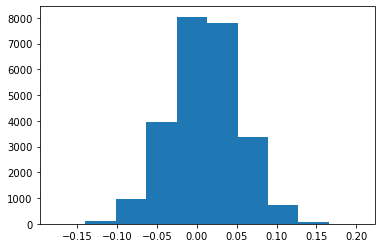

In [6]:
pl.hist(trend_solar)
np.percentile(trend_solar,(5,50,95))

In [7]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
forcing['solar'] = np.zeros((270, samples))
forcing['solar'] = df.solar_erf.loc[1750:2019]

## Volcanic forcing

Use the stratospheric optical depth time series from a combination of Toohey and Sigl (2017; -500 to 1900), CMIP6 (1850-2014), and Glossac (1979-2019). Smoothed overlaps to transition between time series. The zero point is the last-2500 year mean.

ERF = -20 * SAOD based on a combination of CMIP5 models (Larson and Portmann, 2016) and CMIP6 models (my analysis).

The pre-industrial is defined as the SOAD reference from 500 BCE to 1750 CE.

In [8]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
forcing['volcanic'] = df.volcanic_erf.loc[1750:2019]

## Aerosol forcing

ERFari is based on emissions to forcing coefficients from Myhre et al (2013) https://acp.copernicus.org/articles/13/1853/2013/. There is not sufficient evidence from CMIP6 AerChemMIP models or any other sources to update these. The uncertainty ranges from each precursor are expanded slightly compared to Myhre et al., in order to reproduce the overall ERFari uncertainty assessment (assumed that uncertainties in individual components are uncorrelated).

ERFaci is based on fits to CMIP6 models from Smith et al. (2020) https://www.essoar.org/doi/abs/10.1002/essoar.10503977.2

Rescale both to the assessed forcings of -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

In [9]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

samples = 25000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.65/NINETY_TO_ONESIGMA, size=samples, random_state=31318990)

ERFari = np.zeros((270,samples))
ERFaci = np.zeros((270,samples))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()

for i in tqdm(range(samples), leave=False):
    ts2010 = np.mean(
        ghan(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
    )
    ts1750 = ghan(
        [
            so2[0],
                bc[0]+
                oc[0],
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
    )
    ERFaci[:,i] = (
        ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

In [10]:
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[97])
nh3_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = nh3_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari = np.zeros((270, samples))
for i in tqdm(range(samples)):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )

In [11]:
beta_bc = 0.3/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = -0.09/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = -0.4/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = -0.11/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari_median = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3 
    )

In [12]:
ERFaci_median = np.percentile(ERFaci, 50, axis=1) * (-1.0)/(np.percentile(ERFaci, 50, axis=1)[255:265].mean())

In [13]:
ERFari_median[-15:-5].mean()

-0.29999999999999993

In [14]:
ERFaci_median[-15:-5].mean()

-1.0000000000000002

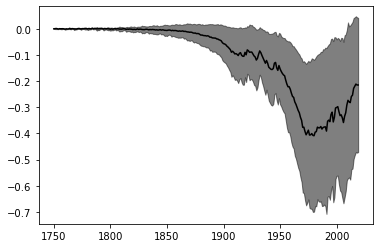

In [15]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari, 5, axis=1), np.percentile(ERFari, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari, 50, axis=1), color='k')

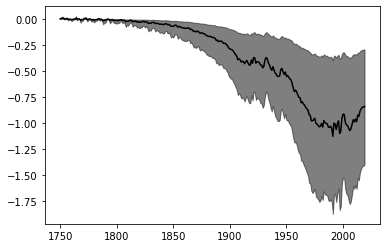

In [16]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFaci, 5, axis=1), np.percentile(ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFaci, 50, axis=1), color='k')

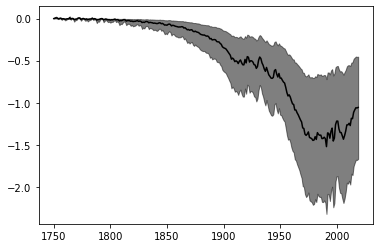

In [17]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari+ERFaci, 5, axis=1), np.percentile(ERFari+ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari+ERFaci, 50, axis=1), color='k')

-1.3


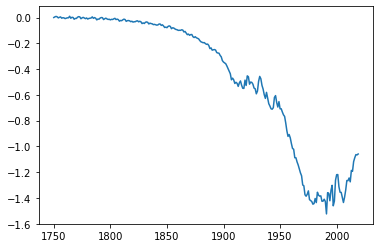

In [18]:
forcing['aerosol-radiation_interactions'] = ERFari_median
forcing['aerosol-cloud_interactions'] = ERFaci_median
forcing['aerosol'] = forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions']
print(forcing['aerosol'][255:265].mean())
pl.plot(forcing['aerosol'])

In [19]:
forcing['aerosol'][-15:]

year
2005   -1.397888
2006   -1.435712
2007   -1.394386
2008   -1.338896
2009   -1.265131
2010   -1.266303
2011   -1.245430
2012   -1.275339
2013   -1.186801
2014   -1.194114
2015   -1.118514
2016   -1.088248
2017   -1.064098
2018   -1.066582
2019   -1.059185
dtype: float64

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

In [20]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/NOx_global_CEDS_emissions_by_sector_2020_09_11.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2019']
avi_nox_hist

,X1750,X1751,X1752,X1753,X1754,X1755,X1756,X1757,X1758,X1759,...,X2010,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1997.776649,2069.475814,2087.063345,2124.952721,2194.826724,2314.759142,2416.613979,2554.457818,2573.144376,2570.985771
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,989.973913,1011.687027,1038.941913,1063.819545,1102.943097,1162.928103,1226.453673,1313.710535,1341.063733,1352.423333


In [21]:
avi_nox_1750_2019 = (avi_nox_hist.sum(axis=0)/1000.).values
contrail_forcing_2018 = 0.0574
forcing['contrails'] = (avi_nox_1750_2019/avi_nox_1750_2019[268] * contrail_forcing_2018)#[:,None] * scale_df['contrails'][None,:]
#pl.plot(np.arange(1750,2020), np.percentile(forcing['contrails'], 95, axis=1))
#pl.plot(np.arange(1750,2020), np.median(forcing['contrails'], axis=1))
#pl.plot(np.arange(1750,2020), np.percentile(forcing['contrails'], 5, axis=1))
forcing['contrails'][-1]

0.05753492821428848

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add -0.05 for irrigation

Based on reading off the graph of the Ghimire paper - could do better maybe but the error will be very small.

In [22]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
ghimire = pd.read_csv('../data_input/ghimire_curve_fit.csv')
landuse_co2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values

In [23]:
lusf2019 = -0.15/np.cumsum(landuse_co2)  # include irrigation of -0.05 in Sherwood et al
landuse_erf = np.cumsum(landuse_co2)*lusf2019
f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
lusf2019 = -0.20/(f(2019)-f(1750))
forcing['land_use'] = lusf2019*(f(np.arange(1750,2020))-f(1750))#[:,None] * scale_df['land_use'][None,:]

## BC on snow

Linear with emissions, 2019 ERF = 0.08

In [24]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/BC_global_CEDS_emissions_by_sector_2020_09_11.csv')
bc_hist = df.loc[:,'X1750':'X2019'].sum(axis=0).values/1000.
bc_hist

forcing['bc_on_snow'] = (0.08*(bc_hist[:270]-bc_hist[0])/(bc_hist[269]-bc_hist[0]))#[:,None] * scale_df['bc_on_snow'][None,:]

## Greenhouse gas concentrations

Here, tropospheric and surface adjustments are only implemented for CO2, CH4, N2O, CFC11 and CFC12. There's an argument to uplift ERF by 5% for other GHGs based on land surface warming, but the total forcing will be very small and no single-forcing studies exist.

Radiative efficiencies for F-gases are from Hodnebrog et al. 2020 https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000691

**TODO 15.01.2021**: add in final update from Jihno Ahn

In [25]:
ghg_obs = pd.read_excel('../data_input/LLGHG_history_AR6_v8a.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
ghg_obs

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124,YYYY
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.70,724.1000,270.0000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1751,278.78,724.9350,270.0250,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1752,278.86,725.7700,270.0500,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1753,278.94,726.6050,270.0750,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1754,279.02,727.4400,270.1000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,399.41,1833.8905,328.3025,83.4145,28.042,9.985158,18.0910,17.5655,6.5970,1.096239,...,0.11,0.0,0.424,0.066,0.62,1.05,0.39897,0.083,1.02,NaN
2016,402.86,1842.0015,329.1240,89.4825,28.950,11.972602,20.4815,19.1555,6.6600,1.205802,...,0.11,0.0,0.416,0.067,0.66,1.04,0.42501,0.083,1.02,NaN
2017,405.00,1849.2615,330.0400,95.7485,29.975,14.153317,23.2450,20.8340,6.8175,1.327504,...,0.11,0.0,0.416,0.067,0.66,1.04,0.43989,0.083,1.02,NaN


In [26]:
gases = ghg_obs.columns.to_list()
gases.remove('YYYY')

In [27]:
forcing['co2'] = np.zeros((270,samples))
forcing['ch4'] = np.zeros((270,samples))
forcing['n2o'] = np.zeros((270,samples))
co2base = np.zeros(270)
ch4base = np.zeros(270)
n2obase = np.zeros(270)
c = np.array([ghg_obs['CO2'].values, ghg_obs['CH4'].values, ghg_obs['N2O'].values])
for i, year in enumerate(range(1750,2020)):
    co2base[i], ch4base[i], n2obase[i] = meinshausen(c[:,i], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)

# include rapid adjustments for CO2 and CH4 (FOD numbers):
forcing['co2'] = 1.05 * co2base
forcing['ch4'] = 0.86 * ch4base
forcing['n2o'] = 1.07 * n2obase

In [28]:
radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888,
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,
    'CFC-112a':     0.24564,
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094, 
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747,
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
}

trop_adjustment_scale = radeff.copy()
for key in trop_adjustment_scale.keys():
    trop_adjustment_scale[key] = 1
trop_adjustment_scale['CFC-11'] = 1.13
trop_adjustment_scale['CFC-12'] = 1.12

otherghgbase = np.zeros(270)
for gas in gases[3:]:
    forcing[gas] = (ghg_obs.loc[:,gas] - ghg_obs.loc[1750,gas]).values * radeff[gas] * 0.001 * trop_adjustment_scale[gas]
    otherghgbase = otherghgbase + forcing[gas]
forcing['other_wmghg'] = otherghgbase

## Ozone

Emissions-based curve fit, with coefficients and uncertainty ranges, from Thornhill et al. 2020 based on AerChemMIP models from CMIP6. Total ozone forcing from 1850-2010 is based on AerChemMIP models from Skeie et al., 2020. See notebook 024.

Downward revision from the new CEDS emissions. Confirm with Bill that this is OK

In [29]:
ods_species = [
    'CCl4',
    'CFC11',
    'CFC113',
    'CFC114',
    'CFC115',
    'CFC12',
    'CH2Cl2',
    'CH3Br',
    'CH3CCl3',
    'CH3Cl',
    'CHCl3',
    'HCFC141b',
    'HCFC142b',
    'HCFC22',
    'Halon1211',
    'Halon1301',
    'Halon2402',
]

ch4 = ghg_obs['CH4'].values
n2o = ghg_obs['N2O'].values
co = emissions_ceds_update['CO'].values.squeeze()
nox = emissions_ceds_update['NOx'].values.squeeze()
voc = emissions_ceds_update['VOC'].values.squeeze()

Text(0.5, 1.0, 'EESC anomaly, ppt')

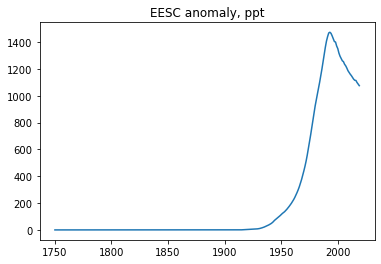

In [30]:
#help(eesc)
ods = np.zeros((270))
for specie in ods_species:
    ods = ods + (eesc(ghg_obs.loc[:2019,rcmip_to_ghg_names[specie]].values.squeeze(), specie))
pl.plot(np.arange(1750,2020), ods)
pl.title('EESC anomaly, ppt')

In [31]:
# radiative efficiencies for ozone forcing - calculated in 024
# CH4 and N2O are W m-2 ppb-1
# ODSs are W m-2 pptEESC-1
# CO, VOC and NOx are W m-2 (Mt yr-1)-1

ozone_rad_eff = {
    'CH4' : 2.17806958e-04,
    'N2O' : 1.08675131e-03,
    'ODS' : -5.99546209e-05,
    'CO' : 7.00793760e-05,
    'VOC' : -4.92424155e-05,
    'NOx' : 1.29886170e-03
}

forcing['o3'] = (
    ozone_rad_eff['CH4'] * (ch4-ch4[0]) +
    ozone_rad_eff['N2O'] * (n2o-n2o[0]) +
    ozone_rad_eff['ODS'] * (ods-ods[0]) +
    ozone_rad_eff['CO'] * (co-co[0]) +
    ozone_rad_eff['VOC'] * (voc-voc[0]) +
    ozone_rad_eff['NOx'] * (nox-nox[0])
)

0.43255486838624185
0.4392671902492208


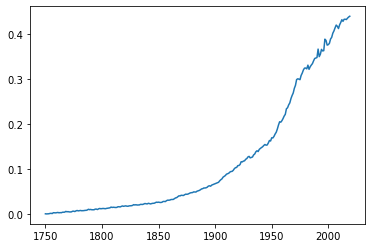

In [32]:
print(forcing['o3'][264])
print(forcing['o3'][269])
pl.plot(np.arange(1750,2020), forcing['o3'])

## Stratospheric water vapour

In [33]:
forcing['ch4'].shape

(270,)

In [34]:
sfh2ostrat = 0.05 / forcing['ch4'][269]
#forcing['h2o_strat'] = (forcing['ch4'] * sfh2ostrat[None,:]) * scale_df['h2o_stratospheric'][None,:]
forcing['h2o_stratospheric'] = (forcing['ch4'] * sfh2ostrat)
forcing['h2o_stratospheric'].shape

(270,)

Text(0.5, 1.0, 'solar')

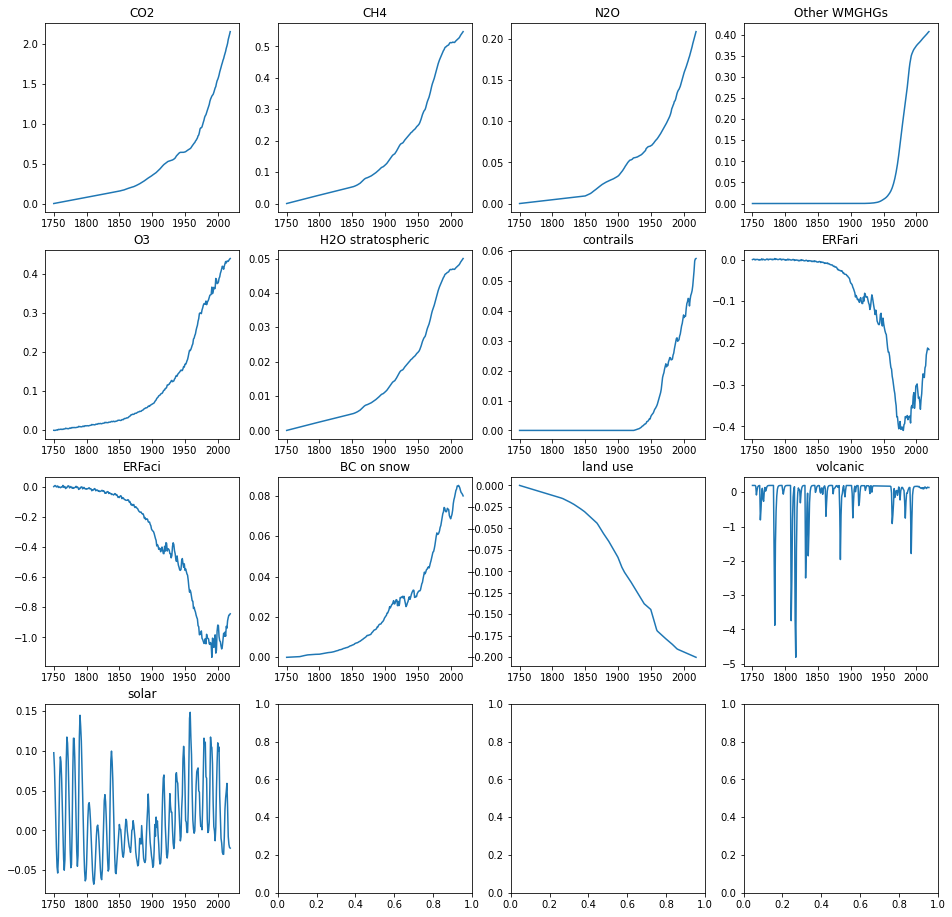

In [35]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].plot(np.arange(1750,2020),forcing['co2'])
ax[0,0].set_title('CO2')
ax[0,1].plot(np.arange(1750,2020),forcing['ch4'])
ax[0,1].set_title('CH4')
ax[0,2].plot(np.arange(1750,2020),forcing['n2o'])
ax[0,2].set_title('N2O')
ax[0,3].plot(np.arange(1750,2020),forcing['other_wmghg'])
ax[0,3].set_title('Other WMGHGs')
ax[1,0].plot(np.arange(1750,2020),forcing['o3'])
ax[1,0].set_title('O3')
ax[1,1].plot(np.arange(1750,2020),forcing['h2o_stratospheric'])
ax[1,1].set_title('H2O stratospheric')
ax[1,2].plot(np.arange(1750,2020),forcing['contrails'])
ax[1,2].set_title('contrails')
ax[1,3].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[1,3].set_title('ERFari')
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,0].set_title('ERFaci')
ax[2,1].plot(np.arange(1750,2020),forcing['bc_on_snow'])
ax[2,1].set_title('BC on snow')
ax[2,2].plot(np.arange(1750,2020),forcing['land_use'])
ax[2,2].set_title('land use')
ax[2,3].plot(np.arange(1750,2020),forcing['volcanic'])
ax[2,3].set_title('volcanic')
ax[3,0].plot(np.arange(1750,2020),forcing['solar'])
ax[3,0].set_title('solar')

In [36]:
forcing['nonco2_wmghg'] = forcing['ch4'] + forcing['n2o'] + forcing['other_wmghg']
forcing['aerosol'] = forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions']
forcing['chapter2_other_anthro'] = ( 
                  forcing['h2o_stratospheric'] + 
                  forcing['contrails'] + 
                  forcing['bc_on_snow'] +
                  forcing['land_use']
)
forcing['total_anthropogenic']=forcing['co2']+forcing['ch4']+forcing['n2o']+\
    forcing['other_wmghg']+\
    forcing['o3']+forcing['h2o_stratospheric']+forcing['contrails']+\
    forcing['aerosol-radiation_interactions']+forcing['aerosol-cloud_interactions']+forcing['bc_on_snow']+forcing['land_use']
forcing['total_natural']=forcing['volcanic']+forcing['solar']
forcing['total']=forcing['total_anthropogenic']+forcing['total_natural']

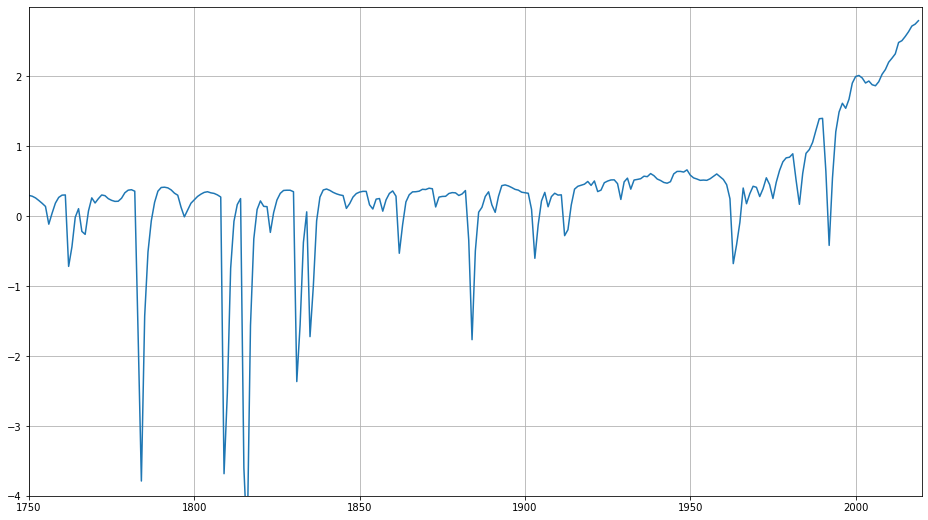

In [37]:
pl.figure(figsize=(16,9))
pl.plot(np.arange(1750,2020), forcing['total'])
pl.yticks(np.arange(-4,3))
pl.xticks(np.arange(1750,2020,50))
pl.ylim(-4,3)
pl.xlim(1750,2020)
pl.grid()

In [38]:
#np.percentile(forcing['total'][-1,:],(5,50,95))
#np.percentile(forcing['total_anthropogenic'][-1,:],(5,50,95))

In [39]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','nonco2_wmghg','aerosol','chapter2_other_anthro',
'total_anthropogenic','total_natural','total']]
df.to_csv('../data_output/AR6_ERF_1750-2019.csv')
df

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199978,0.097590,0.000000,0.000000,0.000000,0.000000,0.297568,0.297568
1751,0.001571,0.000543,0.000093,7.958010e-10,-0.000253,0.000050,0.000000,0.000601,0.004743,0.000017,-0.000229,0.199990,0.079244,0.000636,0.005344,-0.000162,0.007136,0.279234,0.286370
1752,0.003142,0.001086,0.000185,1.591602e-09,-0.000168,0.000099,0.000000,0.001247,0.007399,0.000035,-0.000458,0.199995,0.049166,0.001271,0.008646,-0.000324,0.012567,0.249161,0.261728
1753,0.004712,0.001629,0.000277,2.387403e-09,0.000082,0.000149,0.000000,0.000537,0.004819,0.000052,-0.000687,0.199996,0.012988,0.001906,0.005356,-0.000486,0.011570,0.212984,0.224554
1754,0.006282,0.002171,0.000370,3.183204e-09,0.000786,0.000198,0.000000,-0.000875,-0.002026,0.000070,-0.000916,0.199996,-0.021427,0.002541,-0.002900,-0.000648,0.006061,0.178570,0.184630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.001776,0.535137,0.196946,4.008734e-01,0.432613,0.048900,0.050999,-0.228510,-0.890004,0.082637,-0.198663,0.109650,0.029197,1.132956,-1.118514,-0.016127,2.432703,0.138847,2.571550
2016,2.050532,0.538162,0.199505,4.026474e-01,0.431967,0.049177,0.053424,-0.219798,-0.868451,0.081655,-0.198998,0.127189,-0.007587,1.140314,-1.088248,-0.014741,2.519824,0.119602,2.639426
2017,2.080581,0.540854,0.202388,4.047327e-01,0.435041,0.049423,0.056725,-0.211978,-0.852121,0.081292,-0.199332,0.150614,-0.017467,1.147974,-1.064098,-0.011892,2.587605,0.133147,2.720752


In [40]:
df.loc[2000:2020]

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
2000,1.552699,0.512465,0.157054,0.374802,0.376106,0.046829,0.038652,-0.301089,-0.918591,0.068669,-0.193651,0.175110,0.110008,1.044321,-1.219680,-0.039501,1.713946,0.285118,1.999064
2001,1.576555,0.511833,0.159499,0.376709,0.379031,0.046771,0.037784,-0.298152,-0.920812,0.069730,-0.193985,0.169849,0.099447,1.048041,-1.218963,-0.039700,1.744965,0.269296,2.014261
2002,1.606972,0.512160,0.161607,0.378402,0.388594,0.046801,0.038350,-0.316748,-0.996005,0.070833,-0.194319,0.176633,0.104735,1.052169,-1.312753,-0.038335,1.696647,0.281368,1.978015
2003,1.645201,0.513707,0.163898,0.379904,0.392293,0.046942,0.038179,-0.332654,-1.023127,0.072814,-0.194654,0.160278,0.043363,1.057510,-1.355780,-0.036718,1.702505,0.203641,1.906146
2004,1.672599,0.513494,0.166031,0.381540,0.401531,0.046923,0.040689,-0.329384,-1.027747,0.076183,-0.194988,0.171193,0.016576,1.061065,-1.357132,-0.031193,1.746869,0.187769,1.934639
2005,1.702703,0.512675,0.168350,0.383248,0.406594,0.046848,0.042421,-0.340762,-1.057126,0.078143,-0.195322,0.143467,-0.009882,1.064273,-1.397888,-0.027910,1.747772,0.133585,1.881357
2006,1.734291,0.512722,0.171084,0.384882,0.413489,0.046852,0.043095,-0.358830,-1.076882,0.079359,-0.195656,0.128362,-0.015888,1.068688,-1.435712,-0.026350,1.754407,0.112474,1.866881
2007,1.759977,0.515327,0.173491,0.386799,0.419636,0.047090,0.044202,-0.335418,-1.058969,0.081129,-0.195990,0.114754,-0.027402,1.075617,-1.394386,-0.023569,1.837275,0.087352,1.924627
2008,1.790986,0.517825,0.176400,0.388815,0.416823,0.047319,0.044006,-0.321557,-1.017339,0.082698,-0.196324,0.131293,-0.029882,1.083040,-1.338896,-0.022301,1.929651,0.101411,2.031063


In [41]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name='year'
df=df[gases[3:]]
df.to_csv('../data_output/AR6_ERF_minorGHGs_1750-2019.csv')
df

,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.013942,0.005359,0.001113,0.004229,0.002951,0.000671,0.000300,0.000036,0.000547,0.000195,...,0.000028,0.000055,0.0,0.000120,0.000016,0.000149,0.000312,0.000060,0.000006,0.000211
2016,0.014956,0.005533,0.001334,0.004788,0.003218,0.000678,0.000329,0.000038,0.000594,0.000212,...,0.000028,0.000055,0.0,0.000117,0.000016,0.000159,0.000309,0.000064,0.000006,0.000211
2017,0.016003,0.005729,0.001577,0.005434,0.003500,0.000694,0.000363,0.000042,0.000646,0.000226,...,0.000028,0.000055,0.0,0.000117,0.000016,0.000159,0.000309,0.000066,0.000006,0.000211


## Uncertainties

In [42]:
forcing_ensemble = {}
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','total_anthropogenic','total_natural','total']]

forcing_ensemble['co2'] = df['co2'].values[:,None] * scale_df['co2'].values[None,:]
forcing_ensemble['ch4'] = df['ch4'].values[:,None] * scale_df['ch4'].values[None,:]
forcing_ensemble['n2o'] = df['n2o'].values[:,None] * scale_df['n2o'].values[None,:]
forcing_ensemble['other_wmghg'] = df['other_wmghg'].values[:,None] * scale_df['other_wmghg'].values[None,:]
forcing_ensemble['o3'] = df['o3'].values[:,None] * scale_df['o3'].values[None,:]
forcing_ensemble['h2o_stratospheric'] = df['h2o_stratospheric'].values[:,None] * scale_df['h2o_stratospheric'].values[None,:]
forcing_ensemble['contrails'] = df['contrails'].values[:,None] * scale_df['contrails'].values[None,:]
forcing_ensemble['aerosol-radiation_interactions'] = ERFari
forcing_ensemble['aerosol-cloud_interactions'] = ERFaci
forcing_ensemble['bc_on_snow'] = df['bc_on_snow'].values[:,None] * scale_df['bc_on_snow'].values[None,:]
forcing_ensemble['land_use'] = df['land_use'].values[:,None] * scale_df['land_use'].values[None,:]
forcing_ensemble['volcanic'] = df['volcanic'].values[:,None] * scale_df['volcanic'].values[None,:]
forcing_ensemble['solar'] = np.linspace(0, trend_solar, 270) + df['solar'].values[:,None] * scale_df['solar'].values[None,:]

Text(0.5, 1.0, 'solar')

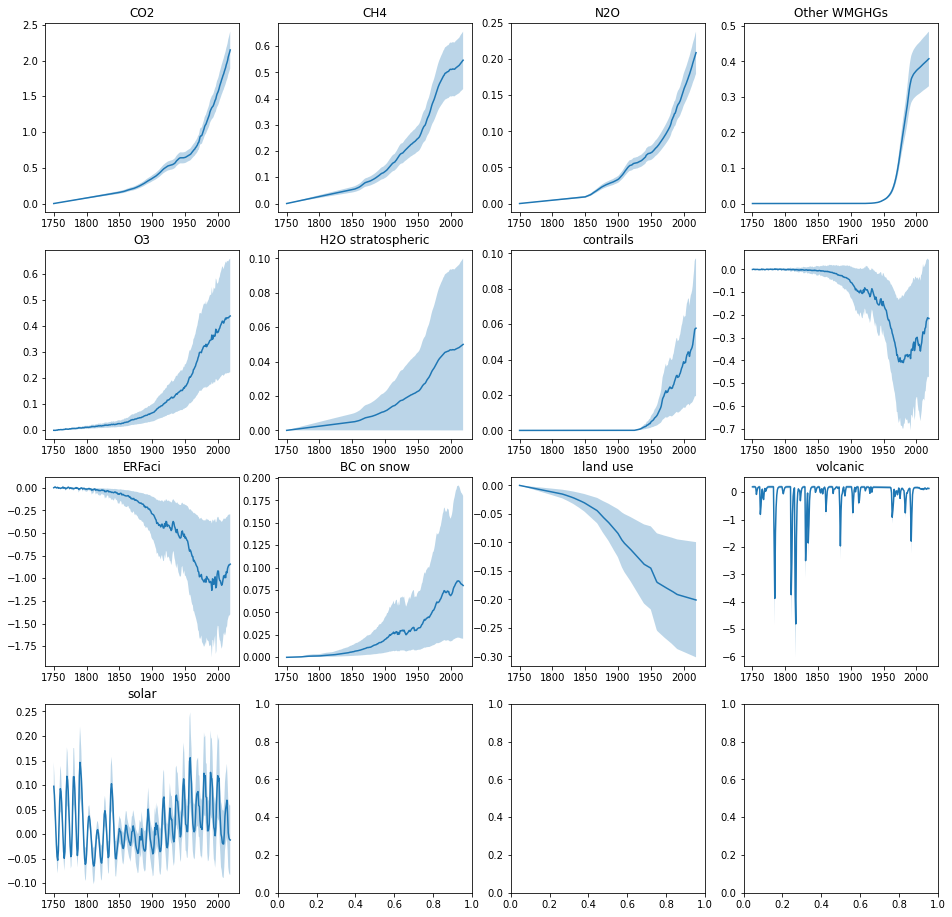

In [43]:
# solar forcing_ensemble will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['co2'],5,axis=1),np.percentile(forcing_ensemble['co2'],95,axis=1), alpha=0.3)
ax[0,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['co2'],axis=1))
ax[0,0].set_title('CO2')
ax[0,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['ch4'],5,axis=1),np.percentile(forcing_ensemble['ch4'],95,axis=1), alpha=0.3)
ax[0,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['ch4'],axis=1))
ax[0,1].set_title('CH4')
ax[0,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['n2o'],5,axis=1),np.percentile(forcing_ensemble['n2o'],95,axis=1), alpha=0.3)
ax[0,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['n2o'],axis=1))
ax[0,2].set_title('N2O')
ax[0,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['other_wmghg'],5,axis=1),np.percentile(forcing_ensemble['other_wmghg'],95,axis=1), alpha=0.3)
ax[0,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['other_wmghg'],axis=1))
ax[0,3].set_title('Other WMGHGs')
ax[1,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['o3'],5,axis=1),np.percentile(forcing_ensemble['o3'],95,axis=1), alpha=0.3)
ax[1,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['o3'],axis=1))
ax[1,0].set_title('O3')
ax[1,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['h2o_stratospheric'],5,axis=1),np.percentile(forcing_ensemble['h2o_stratospheric'],95,axis=1), alpha=0.3)
ax[1,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['h2o_stratospheric'],axis=1))
ax[1,1].set_title('H2O stratospheric')
ax[1,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['contrails'],5,axis=1),np.percentile(forcing_ensemble['contrails'],95,axis=1), alpha=0.3)
ax[1,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['contrails'],axis=1))
ax[1,2].set_title('contrails')
ax[1,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1),np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1), alpha=0.3)
ax[1,3].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[1,3].set_title('ERFari')
ax[2,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1),np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1), alpha=0.3)
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,0].set_title('ERFaci')
ax[2,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['bc_on_snow'],5,axis=1),np.percentile(forcing_ensemble['bc_on_snow'],95,axis=1), alpha=0.3)
ax[2,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['bc_on_snow'],axis=1))
ax[2,1].set_title('BC on snow')
ax[2,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['land_use'],5,axis=1),np.percentile(forcing_ensemble['land_use'],95,axis=1), alpha=0.3)
ax[2,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['land_use'],axis=1))
ax[2,2].set_title('land use')
ax[2,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['volcanic'],5,axis=1),np.percentile(forcing_ensemble['volcanic'],95,axis=1), alpha=0.3)
ax[2,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['volcanic'],axis=1))
ax[2,3].set_title('volcanic')
ax[3,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['solar'],5,axis=1),np.percentile(forcing_ensemble['solar'],95,axis=1), alpha=0.3)
ax[3,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['solar'],axis=1))
ax[3,0].set_title('solar')

In [44]:
print(np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1)[255:265].mean())

forcing_ensemble['total']=(forcing_ensemble['co2'] +
                  forcing_ensemble['ch4'] +
                  forcing_ensemble['n2o'] +
                  forcing_ensemble['other_wmghg'] +
                  forcing_ensemble['o3'] +
                  forcing_ensemble['h2o_stratospheric'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use'] +
                  forcing_ensemble['aerosol-radiation_interactions'] + 
                  forcing_ensemble['aerosol-cloud_interactions'] +
                  forcing_ensemble['solar'] +
                  forcing_ensemble['volcanic'])
forcing_ensemble['aerosol'] = (forcing_ensemble['aerosol-radiation_interactions'] + forcing_ensemble['aerosol-cloud_interactions'])
forcing_ensemble['nonco2_wmghg'] = (forcing_ensemble['ch4'] + forcing_ensemble['n2o'] + forcing_ensemble['other_wmghg'])
forcing_ensemble['chapter2_other_anthro'] = ( 
                  forcing_ensemble['h2o_stratospheric'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use']
)
forcing_ensemble['total_natural'] = forcing_ensemble['solar'] + forcing_ensemble['volcanic']
forcing_ensemble['total_anthropogenic']=(forcing_ensemble['co2'] +
                  forcing_ensemble['ch4'] +
                  forcing_ensemble['n2o'] +
                  forcing_ensemble['other_wmghg'] +
                  forcing_ensemble['o3'] + 
                  forcing_ensemble['h2o_stratospheric'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use'] +
                  forcing_ensemble['aerosol-radiation_interactions'] + 
                  forcing_ensemble['aerosol-cloud_interactions'])

-0.5946721534872019
-0.004246753325492801
-1.6483899696984754
-0.3486441684960516


In [45]:
df = pd.DataFrame(data=np.array([
    np.percentile(forcing_ensemble['co2'],5,axis=1),
    np.percentile(forcing_ensemble['ch4'],5,axis=1),
    np.percentile(forcing_ensemble['n2o'],5,axis=1),
    np.percentile(forcing_ensemble['other_wmghg'],5,axis=1),
    np.percentile(forcing_ensemble['o3'],5,axis=1),
    np.percentile(forcing_ensemble['h2o_stratospheric'],5,axis=1),
    np.percentile(forcing_ensemble['contrails'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1),
    np.percentile(forcing_ensemble['bc_on_snow'],5,axis=1),
    np.percentile(forcing_ensemble['land_use'],5,axis=1),
    np.percentile(forcing_ensemble['volcanic'],5,axis=1),    
    np.percentile(forcing_ensemble['solar'],5,axis=1),
    np.percentile(forcing_ensemble['nonco2_wmghg'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol'],5,axis=1),
    np.percentile(forcing_ensemble['chapter2_other_anthro'],5,axis=1),
    np.percentile(forcing_ensemble['total_anthropogenic'],5,axis=1),
    np.percentile(forcing_ensemble['total_natural'],5,axis=1),
    np.percentile(forcing_ensemble['total'],5,axis=1)
]).T, index=np.arange(1750,2020))
df.index.name = 'year'
df = df.rename(columns={
    0: 'co2',
    1: 'ch4',
    2: 'n2o',
    3: 'other_wmghg',
    4: 'o3',
    5: 'h2o_stratospheric',
    6: 'contrails',
    7: 'aerosol-radiation_interactions',
    8: 'aerosol-cloud_interactions',
    9:'bc_on_snow',
    10:'land_use',
    11:'volcanic',
    12:'solar',
    13:'nonco2_wmghg',
    14:'aerosol',
    15:'chapter2_other_anthro',
    16:'total_anthropogenic',
    17:'total_natural',
    18:'total'
})
df.to_csv('../data_output/AR6_ERF_1750-2019_pc05.csv')
df

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.148885,0.048934,0.000000,0.000000,0.000000,0.000000,0.227106,0.227106
1751,0.001381,0.000433,0.000080,6.436025e-10,-0.000380,-3.363253e-08,0.000000,-0.000914,0.000856,0.000004,-0.000345,0.148895,0.039767,0.000525,0.001117,-0.000287,0.002894,0.214678,0.222462
1752,0.002761,0.000866,0.000159,1.287205e-09,-0.000251,-6.724324e-08,0.000000,-0.001058,0.001294,0.000009,-0.000691,0.148898,0.024698,0.001049,0.002025,-0.000574,0.005929,0.192738,0.205764
1753,0.004142,0.001298,0.000239,1.930808e-09,0.000042,-1.008322e-07,0.000000,-0.001022,0.000845,0.000013,-0.001036,0.148899,0.006573,0.001573,0.001026,-0.000861,0.007167,0.161676,0.173849
1754,0.005521,0.001731,0.000318,2.574410e-09,0.000399,-1.343994e-07,0.000000,-0.001427,-0.005817,0.000018,-0.001382,0.148899,-0.031976,0.002097,-0.006697,-0.001148,0.002091,0.126996,0.132702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1.759405,0.426555,0.169434,3.242056e-01,0.219417,-3.312380e-05,0.017203,-0.497179,-1.468565,0.021320,-0.299569,0.081635,-0.031736,0.996530,-1.753785,-0.145661,1.707342,0.072514,1.853328
2016,1.802258,0.428966,0.171635,3.256403e-01,0.219089,-3.331106e-05,0.018021,-0.482590,-1.438174,0.021067,-0.300073,0.094694,-0.067131,1.003152,-1.712179,-0.144551,1.802256,0.052942,1.928760
2017,1.828669,0.431112,0.174116,3.273268e-01,0.220648,-3.347769e-05,0.019134,-0.471116,-1.412995,0.020973,-0.300577,0.112133,-0.077698,1.010221,-1.678121,-0.142143,1.874733,0.063078,2.012553


In [46]:
df = pd.DataFrame(data=np.array([
    np.percentile(forcing_ensemble['co2'],95,axis=1),
    np.percentile(forcing_ensemble['ch4'],95,axis=1),
    np.percentile(forcing_ensemble['n2o'],95,axis=1),
    np.percentile(forcing_ensemble['other_wmghg'],95,axis=1),
    np.percentile(forcing_ensemble['o3'],95,axis=1),
    np.percentile(forcing_ensemble['h2o_stratospheric'],95,axis=1),
    np.percentile(forcing_ensemble['contrails'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1),
    np.percentile(forcing_ensemble['bc_on_snow'],95,axis=1),
    np.percentile(forcing_ensemble['land_use'],95,axis=1),
    np.percentile(forcing_ensemble['volcanic'],95,axis=1),    
    np.percentile(forcing_ensemble['solar'],95,axis=1),
    np.percentile(forcing_ensemble['nonco2_wmghg'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol'],95,axis=1),
    np.percentile(forcing_ensemble['chapter2_other_anthro'],95,axis=1),
    np.percentile(forcing_ensemble['total_anthropogenic'],95,axis=1),
    np.percentile(forcing_ensemble['total_natural'],95,axis=1),
    np.percentile(forcing_ensemble['total'],95,axis=1)
]).T, index=np.arange(1750,2020))
df.index.name = 'year'
#df=df[['co2','ch4','n2o','other_wmghg','o3_trop','other_anthro','aerosols','volcanic','solar','total']]
df = df.rename(columns={
    0: 'co2',
    1: 'ch4',
    2: 'n2o',
    3: 'other_wmghg',
    4: 'o3',
    5: 'h2o_stratospheric',
    6: 'contrails',
    7: 'aerosol-radiation_interactions',
    8: 'aerosol-cloud_interactions',
    9:'bc_on_snow',
    10:'land_use',
    11:'volcanic',
    12:'solar',
    13:'nonco2_wmghg',
    14:'aerosol',
    15:'chapter2_other_anthro',
    16:'total_anthropogenic',
    17:'total_natural',
    18:'total'
})
df.to_csv('../data_output/AR6_ERF_1750-2019_pc95.csv')
df

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250387,0.146440,0.000000,0.000000,0.000000,0.000000,0.367697,0.367697
1751,0.001759,0.000651,0.000106,9.439035e-10,-0.000128,0.000099,0.000000,0.002115,0.014385,0.000039,-0.000114,0.250402,0.118925,0.000744,0.015041,-0.000034,0.016842,0.343167,0.352042
1752,0.003517,0.001301,0.000211,1.887807e-09,-0.000085,0.000199,0.000000,0.003548,0.022610,0.000078,-0.000228,0.250407,0.073852,0.001487,0.023981,-0.000068,0.027839,0.305300,0.320611
1753,0.005275,0.001951,0.000317,2.831710e-09,0.000123,0.000298,0.000000,0.002094,0.014689,0.000118,-0.000342,0.250409,0.019661,0.002230,0.015295,-0.000102,0.021514,0.264215,0.277341
1754,0.007032,0.002600,0.000422,3.775614e-09,0.001179,0.000397,0.000000,-0.000327,-0.000422,0.000157,-0.000456,0.250410,-0.010527,0.002972,-0.001189,-0.000136,0.008120,0.230412,0.236118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.240869,0.640773,0.224685,4.754779e-01,0.648884,0.097785,0.086116,0.041385,-0.308983,0.185910,-0.098822,0.137289,0.109783,1.264347,-0.477355,0.139800,3.187658,0.224690,3.342374
2016,2.295450,0.644395,0.227604,4.775821e-01,0.647914,0.098337,0.090211,0.044119,-0.301162,0.183702,-0.098988,0.159250,0.071512,1.272544,-0.463764,0.140817,3.265069,0.206333,3.399547
2017,2.329087,0.647619,0.230893,4.800555e-01,0.652525,0.098829,0.095785,0.048115,-0.295339,0.182883,-0.099154,0.188579,0.062194,1.281007,-0.450833,0.144219,3.324993,0.222819,3.474460


## For chapter: use 2005-14 forcing for aerosols

In [47]:
forcing['aerosol'].loc[2005:2014].mean()

-1.3

In [48]:
forcing['total_anthropogenic'][2019] - forcing['aerosol'][2019] + forcing['aerosol'].loc[2005:2014].mean()

2.439655101719506

In [49]:
aerosol_wangle = np.percentile(
    forcing_ensemble['co2'][269]+
    forcing_ensemble['ch4'][269]+
    forcing_ensemble['n2o'][269]+
    forcing_ensemble['other_wmghg'][269]+
    forcing_ensemble['o3'][269]+
    forcing_ensemble['h2o_stratospheric'][269]+
    forcing_ensemble['contrails'][269]+
    forcing_ensemble['bc_on_snow'][269]+
    forcing_ensemble['land_use'][269]+
    forcing_ensemble['aerosol'][255:265,:].mean(axis=0)
,(5,95))
np.savetxt('../data_output/AR6_ERF_1750-PD_pc05pc95_anthro_assessed.csv', aerosol_wangle)
aerosol_wangle

array([1.64419168, 3.26919941])

In [50]:
forcing['total_anthropogenic'][2019]

2.68047034879458

In [51]:
np.percentile(forcing_ensemble['total_anthropogenic'][269], (5,95))

array([1.96677626, 3.41508378])

## For Kyle

In [52]:
print('Total 2006-19 minus 1850-1900, 5th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 5) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 5))
print('Total 2006-19 minus 1850-1900, best', forcing['total'][256:270].mean() - forcing['total'][100:151].mean())
print('Total 2006-19 minus 1850-1900, 50th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 50) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 50))
print('Total 2006-19 minus 1850-1900, 95th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 95) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 95))
print()
print('CO2 2006-19 minus 1850-1900, 5th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 5) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 5))
print('CO2 2006-19 minus 1850-1900, best', forcing['co2'][256:270].mean() - forcing['co2'][100:151].mean())
print('CO2 2006-19 minus 1850-1900, 50th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 50) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 50))
print('CO2 2006-19 minus 1850-1900, 95th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 95) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 95))

Total 2006-19 minus 1850-1900, 5th 1.5950213558318422
Total 2006-19 minus 1850-1900, best 2.1660631466006013
Total 2006-19 minus 1850-1900, 50th 2.180554421618147
Total 2006-19 minus 1850-1900, 95th 2.838192033817844

CO2 2006-19 minus 1850-1900, 5th 1.4900816235481893
CO2 2006-19 minus 1850-1900, best 1.6953510015962816
CO2 2006-19 minus 1850-1900, 50th 1.695643051994218
CO2 2006-19 minus 1850-1900, 95th 1.8978450595038974


In [53]:
forcing_ensemble['total'].shape

(270, 25000)

## For Matt

In [54]:
forcing_ensemble['year'] = np.arange(1750, 2020)
save_dict_to_hdf5(forcing_ensemble, '../data_input_large/ERF_ensemble.h5')